In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_tr = pd.read_csv('../Data/X_train.csv')

In [3]:
X_tst = pd.read_csv('../Data/X_test.csv')

In [4]:
y_train = pd.read_csv('../Data/y_train.csv')

In [5]:
y_test = pd.read_csv('../Data/y_test.csv')

In [6]:
X = pd.concat([X_tr, X_tst], ignore_index=True)

In [7]:
y = pd.concat([y_train, y_test], ignore_index=True)

In [8]:
X_train = X_tr.iloc[:, 1:]
X_test = X_tst.iloc[:, 1:]

In [9]:
X2 = X.iloc[:, 1:]

# Reorder

In [10]:
order = ['CB', 'CF', 'CM', 'DM', 'AM', 'WM', 'FB', 'WF']

In [11]:
y = y[order]
y_train = y_train[order].to_numpy()
y_test = y_test[order].to_numpy()

# Classification

In [12]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, hamming_loss
from sklearn.metrics import precision_recall_curve

In [13]:
clf = ClassifierChain(RandomForestClassifier())

In [14]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [15]:
clf.fit(X_train, y_train)

ClassifierChain(classifier=RandomForestClassifier(), require_dense=[True, True])

In [16]:
y_pred = clf.predict(X_test).toarray()
y_proba = clf.predict_proba(X_test).toarray()

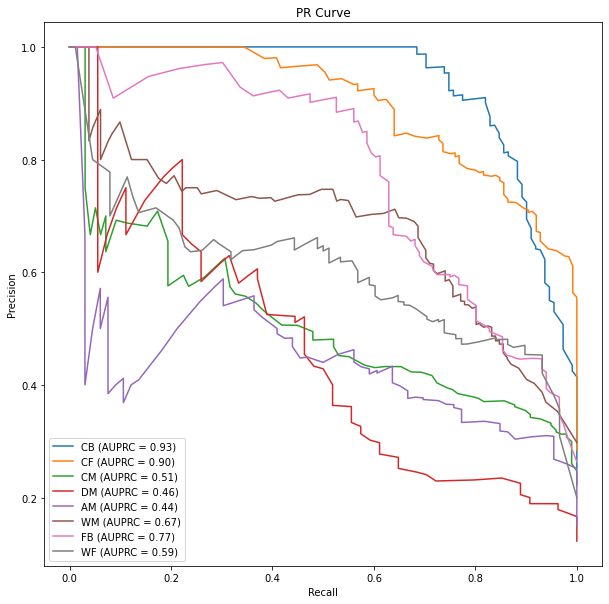

In [17]:
precision = [0 for i in range(8)]
recall = [0 for i in range(8)]
ap = [0 for i in range(8)]
for i in range(8):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_proba[:, i])
    ap[i] = average_precision_score(y_test[:, i], y_proba[:, i])
        
plt.figure(figsize=(10,10))
for i in range(8):
    plt.plot(recall[i], precision[i], label=f"{order[i]} (AUPRC = {ap[i]:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("PR Curve")
plt.legend(loc="lower left")
plt.show()

# CV

In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import average_precision_score

In [19]:
kfold = KFold(n_splits=5)

In [20]:
X2 = X.iloc[:, 1:].to_numpy()
y = y.to_numpy()

In [21]:
n_iter =0
mAP_lst = []
hl_lst = []
for train_index, test_index in kfold.split(X2):  
    x_train, x_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(x_train, y_train)
    y_proba = clf.predict_proba(x_test).toarray()
    y_pred = clf.predict(x_test).toarray()
    n_iter += 1
    
    mAP = np.round(average_precision_score(y_test, y_proba), 4)
    mAP_lst.append(mAP)
    hl = np.round(hamming_loss(y_test, y_pred), 4)
    hl_lst.append(hl)
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 mAP : {1}, Hamming Loss : {2}  학습 데이터 크기 : {3},  검증 데이터 크기 : {4}'
          .format(n_iter, mAP, hl, train_size, test_size))
    
print('\n 평균 : mAP : {0}, Hamming Loss : {1}'.format(np.mean(mAP_lst), np.mean(hl_lst)))


#1 교차 검증 mAP : 0.6763, Hamming Loss : 0.1592  학습 데이터 크기 : 1153,  검증 데이터 크기 : 289

#2 교차 검증 mAP : 0.6328, Hamming Loss : 0.1592  학습 데이터 크기 : 1153,  검증 데이터 크기 : 289

#3 교차 검증 mAP : 0.6553, Hamming Loss : 0.1567  학습 데이터 크기 : 1154,  검증 데이터 크기 : 288

#4 교차 검증 mAP : 0.6418, Hamming Loss : 0.1558  학습 데이터 크기 : 1154,  검증 데이터 크기 : 288

#5 교차 검증 mAP : 0.6486, Hamming Loss : 0.1428  학습 데이터 크기 : 1154,  검증 데이터 크기 : 288

 평균 : mAP : 0.65096, Hamming Loss : 0.15474000000000002


In [22]:
y_pred = clf.predict_proba(X_test)

In [25]:
output = pd.DataFrame(y_pred.toarray())

In [26]:
output.columns = order

In [28]:
output.head()

,CB,CF,CM,DM,AM,WM,FB,WF
0,0.01,0.79,0.73,0.00,0.15,0.94,0.04,0.00
1,0.08,0.03,0.15,0.14,0.00,0.93,0.97,0.00
2,0.00,0.91,0.06,0.00,0.21,0.05,0.01,0.88
3,0.00,0.98,0.00,0.00,0.11,0.00,0.00,0.09
4,0.01,0.23,0.75,0.00,0.05,0.92,0.73,0.03


In [31]:
df_join = pd.merge(X_tst, output, left_index=True, right_index=True)

In [33]:
df_join.to_csv('output.csv', index=False)